In [ ]:
!pip install demoji
!pip install WordCloud
!pip install pyLDAvis

# Basic
import numpy as np
import pandas as pd

# Data Cleaning
import re
import string
import demoji
demoji.download_codes()

# Data Pre-processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Buidling the LDA model
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim
import pyLDAvis.sklearn
from sklearn.model_selection import *
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

... OK (Got response in 0.20 seconds)
Writing emoji data to C:\Users\xuming.shi\.demoji\codes.json ...
... OK


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xuming.shi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df=pd.read_csv('20201117_230813_covid_tweets_50000.csv')
df.head(5)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,2008-09-18 01:08:47,2020-11-17 18:07:31,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]"
1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,2009-01-17 06:58:29,2020-11-17 18:07:31,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]"
2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,2013-12-05 14:03:36,2020-11-17 18:07:31,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]"
3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,2007-06-05 14:47:23,2020-11-17 18:07:31,0,The area of arctic sea ice that didn't melt be...,[]
4,JoelJeffcoat,NaN,NaN,293,113,19637,2017-04-18 18:30:24,2020-11-17 18:07:31,30,This is where we are. CEOs of the American Hos...,[]


# Data Cleaning 

In [ ]:
# Remove URL

def remove_URL(text):
    url = re.compile(r'http\S+')
    return url.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [ ]:
# Remove html tags

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [ ]:
# Remove emojis

def remove_emojis(text):
  new_text = demoji.replace(text, "")
  return new_text

df['text'] = df['text'].apply(lambda x: remove_emojis(x))

In [ ]:
# Remove mentions and hashtag

def remove_mention_hashtag(text):
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    return text

df['text']=df['text'].apply(lambda x: remove_mention_hashtag(x))

In [ ]:
# Remove Emails

def remove_emails(text):
  email = re.compile(r'\S*@\S*\s?')
  return email.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emails(x))

In [ ]:
# Remove new line characters

def remove_newline(text):
  newline = re.compile(r'\n+')
  return newline.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_newline(x))

In [ ]:
# Remove extra white space left while removing stuff

def remove_space(text):
    whitespace_remove = re.compile(r'\s+')
    return whitespace_remove.sub(r' ', text)

df["text"]=df["text"].apply(lambda x: remove_space(x))

# Data Pre-processing

In [ ]:
punct=string.punctuation+'”‘’“'

def clean_text(text):
#Make text lowercase
    text = text.lower()
#remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
#remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text)    
#remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

tweets_df_clean = pd.DataFrame(df["text"].apply(lambda x: clean_text(x)))

In [ ]:
# remove stopwords
stopwords = nltk.corpus.stopwords.words("english")
custom_stopwords = ['hi', '&amp;', 'amp', 'amp;', 'got', "it's", 'it’s', "i'm", 'im', 'want', 'like', '$', '@','covid','coronavirus','covid19','covid-19']
for i in custom_stopwords:
    stopwords.append(i)

def remove_stopwords(text):
    return " ".join(word for word in str(text).split() if word not in stopwords)
    
tweets_df_clean['text']=tweets_df_clean['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xuming.shi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Tokenization
tweets_df_clean["text"] = tweets_df_clean["text"].apply(word_tokenize)

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xuming.shi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Lemmatization 
def lemmatizing(text):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

tweets_df_clean["text"] = tweets_df_clean["text"].apply(lambda x: lemmatizing(x))

## Exploratory Analysis

### Tweets Character Length

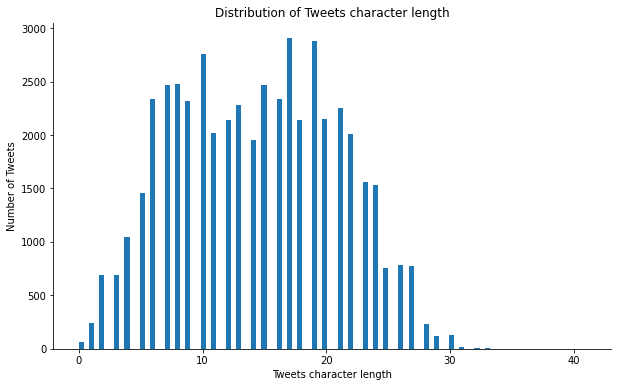

In [ ]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

### Wordcloud

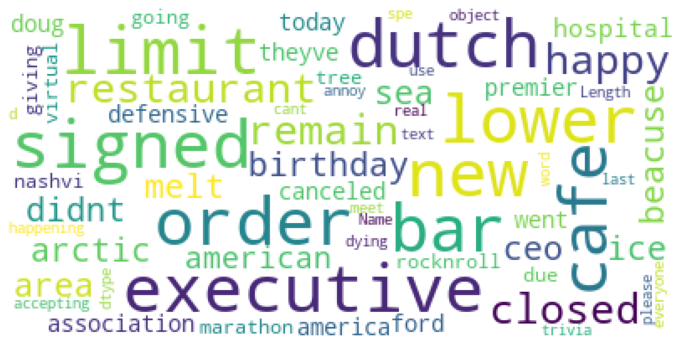

In [ ]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                      background_color='white',
                      stopwords=stopwords,
                      max_words=500,
                      max_font_size=40, 
                      random_state=100
                      ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
# Flatten tweets
flat_list = [item for sublist in tweets_df_clean.text for item in sublist]

# CountVectorize
vectorizer = CountVectorizer(
                            analyzer='word',       
                            min_df=3, # minimum required occurences of a word 
                            token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
                            max_features=5000, # max number of unique words
                            )
data_matrix = vectorizer.fit_transform(flat_list)

# The 10 most common words
sum_words = data_matrix.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('people', 5882),
 ('case', 5666),
 ('new', 4984),
 ('vaccine', 4852),
 ('pandemic', 3757),
 ('death', 3644),
 ('mask', 3374),
 ('one', 3039),
 ('need', 2899),
 ('help', 2714),
 ('today', 2689),
 ('health', 2657),
 ('world', 2611),
 ('test', 2593),
 ('get', 2475),
 ('senate', 2355),
 ('virus', 2203),
 ('say', 2157),
 ('year', 2155),
 ('family', 2072)]

-------
# Building the LDA model

#### Baseline Model with The Number of Topics = 10

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(
                                      n_components=10, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix) 

In [ ]:
# Create topic distance visualization 
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

## Select of the best number of topics (K) for our model

##### The Number of Topics = 3

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(
                                      n_components = 3, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix) 

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

##### The Number of Topics = 4

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(
                                      n_components = 4, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix) 

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

##### The Number of Topics = 5

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(
                                      n_components = 5, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

##### The Number of Topics = 6

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(
                                      n_components = 6, # Number of topics
                                      learning_method='online',
                                      random_state=20,       
                                      n_jobs = -1  # Use all available CPUs
                                     )


In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

##### The Number of Topics = 7

In [ ]:
# LDA
lda_model= = LatentDirichletAllocation(
                                        n_components = 7, # Number of topics
                                        learning_method='online',
                                        random_state=20,       
                                        n_jobs = -1  # Use all available CPUs
                                       )
lda_output = lda_model.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

##### The Number of Topics = 8

In [ ]:
# LDA
lda_model= = LatentDirichletAllocation(
                                        n_components = 8, # Number of topics
                                        learning_method='online',
                                        random_state=20,       
                                        n_jobs = -1  # Use all available CPUs
                                       )
lda_output = lda_model.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

##### The Number of Topics = 9

In [ ]:
# LDA
lda_model= = LatentDirichletAllocation(
                                        n_components = 9, # Number of topics
                                        learning_method='online',
                                        random_state=20,       
                                        n_jobs = -1  # Use all available CPUs
                                       )
lda_output = lda_model.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

## Calculate Probability Using Genism

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(list(tweets_df_clean["text"]))

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
                          num_topics=8, # Number of topics          ----> need to put our final K here
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 10,
                          per_word_topics=True
                          )


In [ ]:
# Print the Keyword in the 10 topics
print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.019*"american" + 0.012*"new" + 0.011*"died" + 0.011*"market" + '
  '0.010*"death" + 0.010*"senate" + 0.009*"security" + 0.009*"make" + '
  '0.009*"million" + 0.009*"trump"'),
 (1,
  '0.013*"people" + 0.010*"please" + 0.009*"dont" + 0.009*"get" + '
  '0.008*"information" + 0.007*"stock" + 0.007*"loeffler" + 0.006*"kelly" + '
  '0.006*"helping" + 0.006*"stop"'),
 (2,
  '0.008*"new" + 0.007*"u" + 0.007*"back" + 0.007*"pandemic" + 0.006*"health" '
  '+ 0.006*"grassley" + 0.006*"would" + 0.006*"republican" + 0.005*"home" + '
  '0.005*"senate"'),
 (3,
  '0.014*"people" + 0.014*"pandemic" + 0.008*"get" + 0.006*"take" + '
  '0.006*"vaccine" + 0.006*"study" + 0.006*"health" + 0.006*"test" + '
  '0.005*"time" + 0.005*"second"'),
 (4,
  '0.035*"vaccine" + 0.018*"data" + 0.017*"effective" + 0.017*"dolly" + '
  '0.017*"parton" + 0.017*"need" + 0.015*"one" + 0.015*"modernas" + '
  '0.013*"nearly" + 0.012*"early"'),
 (5,
  '0.043*"case" + 0.021*"new" + 0.015*"death" + 

In [ ]:
new_text = 'i vaccine dolly moderna'
tokens = [token for token in word_tokenize(new_text.lower())]
result=lda_model_2[id2word.doc2bow(tokens)]
result[0]

[(0, 0.025123056),
 (1, 0.025122585),
 (2, 0.025121229),
 (3, 0.025124274),
 (4, 0.6277717),
 (5, 0.025129134),
 (6, 0.22148177),
 (7, 0.025126316)]

In [ ]:
# Compute Perplexity 
base_perplexity = lda_model_2.log_perplexity(corpus)
print("\nPerplexity: ", base_perplexity)

# Compute Coherence Score
coherence_model = CoherenceModel(model = lda_model_2, texts = tweets_df_clean["text"],
                                 coherence = "c_v")
coherence_lda_model_base = coherence_model.get_coherence()
print("\nCoherence Score: ", coherence_lda_model_base)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)